In [1]:
import pandas as pd
import numpy as np
import re
from geopy.geocoders import Nominatim
import pickle
import geopandas
from shapely.geometry import Point
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# DATA LOADING & CONDITIONING

---

### **setting** analysis parameters:

In [2]:
yr = "2099"  # year (string)

nLectures = 3  # nr. of lectures

bGetCoordNominatim = False  # (re)get coordinates of all the locations from Nominatim (limited nr. of queries per day, careful!)

nominatim_user="unife_corso_eccellenza_"+yr  # name of the Nominatim user

lsRegions = {  # dictionary to couple region names gotten from Nominatim (keys) & from the map files (values)
    "Piemonte" : "PIEMONTE",
    "Valle d'Aosta/Vallée d'Aoste" : "VALLE D'AOSTA/VALLÉE D'AOSTE\r\nVALLE D'AOSTA/VALLÉE D'AOSTE",
    "Lombardia" : "LOMBARDIA",
    "Trentino-Alto Adige/Südtirol" : "TRENTINO-ALTO ADIGE/SUDTIROL",
    "Veneto" : "VENETO",
    "Friuli Venezia Giulia" : "FRIULI VENEZIA GIULIA",
    "Liguria" : "LIGURIA",
    "Emilia-Romagna" : "EMILIA-ROMAGNA",
    "Toscana" : "TOSCANA",
    "Umbria" : "UMBRIA",
    "Marche" : "MARCHE",
    "Lazio" : "LAZIO",
    "Abruzzo" : "ABRUZZO",
    "Molise" : "MOLISE",
    "Campania" : "CAMPANIA",
    "Puglia" : "PUGLIA",
    "Basilicata" : "BASILICATA",
    "Calabria" : "CALABRIA",
    "Sicilia" : "SICILIA",
    "Sardegna" : "SARDEGNA",
}

fontsize = 16  # fontsize to be used everywhere in the plots

bSavePlots = True  # save all plots/charts?

fmt = "png"  # output image format

---

In [3]:
# open attendance data
df_data = pd.read_csv("out_data/%s/presences_total.txt" % yr, names=["id", "surname", "firstName", "institution_location", "nLectures", "nHours"], engine='python', delimiter=", ")

# also open data on zero-lecture attenders & add them to df_data
if yr=="2021":
    ix, sn, fn, il = np.genfromtxt("out_data/%s/attenders_zero_lectures.txt" % yr, unpack=True, dtype="str", delimiter=", ")
else:
    ix, sn, fn, nn, il = np.genfromtxt("out_data/%s/attenders_zero_lectures.txt" % yr, unpack=True, dtype="str", delimiter=", ")
nl = np.zeros(len(sn))
df_data0 = {
    "id" : ix,
    "firstName" : fn,
    "surname" : sn, 
    "institution_location" : il, 
    "nLectures" : nl, 
    "nHours" : nl
}
df_data = pd.concat((df_data, pd.DataFrame(data=df_data0)), ignore_index=True)

# also open data on attendance to each lecture & add them to df_data
for i in range(nLectures):
    ix, sn, fn, att = np.genfromtxt("out_data/%s/presences_lecture%d.txt" % (yr, i), unpack=True, dtype="str", delimiter=",", autostrip=True)
    for ix0, sn0, fn0, att0 in zip(ix, sn, fn, att):
        df_data.loc[(df_data.surname==sn0) & (df_data.firstName.fillna("")==fn0), "presence%d" % i] = False if att0=="absent" else True
        # note: here the possibility of NaN firstName (but not surname) in the attendance data is taken into account

C:\Users\succo\AppData\Local\Temp\ipykernel_10012\2619203940.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_data.loc[(df_data.surname==sn0) & (df_data.firstName.fillna("")==fn0), "presence%d" % i] = False if att0=="absent" else True
C:\Users\succo\AppData\Local\Temp\ipykernel_10012\2619203940.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_data.loc[(df_data.surname==sn0) & (df_data.firstName.fillna("")==fn0), "presence%d" % i] = False if att0=="absent" else True
C:\Users\succo\AppData\Local\Temp\ipykernel_10012\2619203940.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas.

---

### **setting** manual tweaking to the final attendance data:

In [4]:
if yr=="2021":  # should not be of use anymore, as now the schools are identified by the codice meccanografico
    df_data.loc[df_data.institution_location=="Giovio_Culo", "institution_location"] = "Giovio_Como"

---

In [5]:
# attending data conditioning

for s in [ss for ss in df_data.institution_location if "LOCATION_MISSING" in ss]:
    print("excluding entries with institution_location = %s" % s)
    df_data = df_data[df_data.institution_location!=s]

df_data["fullName"] = df_data["firstName"].replace(np.nan, '', regex=True) + " " + df_data["surname"].replace(np.nan, '', regex=True) # add fullName entry (firstName + space + surname)
df_data["fullName_institution_location"] = df_data["fullName"].apply(lambda s : s.replace(" ", "")) + "_" + df_data['institution_location']  # add fullName_institution_location (fullName (w/ no spaces) + _ + institution_location)
df_data[['institution', 'locationName']] = df_data['institution_location'].str.split(pat='_', n=1, expand=True)  # separate institution & locationName
df_data["institution"] = df_data["institution"].apply(lambda s : re.sub( r"([A-Z])", r" \1", s)[1:])  # separate locationName single words
df_data["locationName"] = df_data["locationName"].apply(lambda s : re.sub( r"([A-Z])", r" \1", s)[1:])  # separate locationName single words

# get coordinates (locationCoord) from locationName -- if manually requested...
if bGetCoordNominatim:
    location = {}
    for i, s in enumerate(df_data.locationName.unique()):
        print("(%d/%d) finding coordinates for %s..." % (i+1, len(df_data.locationName.unique()), s))
        if not (s in location.keys()):
            location.update({s : Nominatim(user_agent=nominatim_user).geocode(s)})
    print("(over)writing all coordinate data in out_data/%s/location_coordinates.pickle" % yr)
    with open('out_data/%s/location_coordinates.pickle' % yr, 'wb') as f:
        pickle.dump(location, f)
        
# ... otherwise get them from Pickle file (check availability)
else:
    print("loading all coordinate data from out_data/%s/location_coordinates.pickle" % yr)
    with open('out_data/%s/location_coordinates.pickle' % yr, 'rb') as f:
        location = pickle.load(f)
        
df_data["locationCoord"] = df_data.locationName.apply(lambda s : location[s])  # finally add locationCoord to DataFrame

# get region from locationCoord, via function findRegion
def findRegion(s):
    i=0
    while not (", "+list(lsRegions.keys())[i]+"," in s):
        i=i+1
    return list(lsRegions.keys())[i]

df_data["region"] = df_data.locationCoord.apply(lambda s : findRegion(s.address))  # finally add region to DataFrame

df_data["latitude"] = df_data.locationCoord.apply(lambda s : s.latitude)  # add latitude to DataFrame
df_data["longitude"] = df_data.locationCoord.apply(lambda s : s.longitude)  # add latitude to DataFrame
df_data["longitude_latitude"] = df_data.locationCoord.apply(lambda s : (s.longitude, s.latitude))  # also add (longitude, latidude)

excluding entries with institution_location = LOCATION_MISSING/SS19510
loading all coordinate data from out_data/2099/location_coordinates.pickle


In [6]:
# open Italy geographical data

bPlotPreliminary = False  # draw preliminary plot?

print("loading Italian map")

# whole country with different regions
df_map_reg = geopandas.read_file(filename="raw_maps/italian-maps-shapefiles-master/italy-with-regions/reg2011_g.shp").to_crs("EPSG:4326")  # WGS84 latitude/longitude coordinate system

if bPlotPreliminary: 
    ax = df_map_reg.boundary.plot(figsize=(6, 6), lw=0.5, color="k")
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%2d'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%2d'))
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    dfBool = False
    for s in df_data.region.unique():
        dfBool = dfBool | (df_map_reg.NOME_REG == lsRegions[s])
    df_map_reg[dfBool].plot(ax = ax, lw=0.5, color="yellow") ;
    ax.grid()
    plt.tight_layout()

# attending regions with different provinces
df_map_prov = geopandas.GeoDataFrame()
for s in df_data.region.unique():
    ss = s.replace(" ", "_").replace("/", "_").replace("'", "_").lower()
    dfTemp = geopandas.read_file(filename="raw_maps/italian-maps-shapefiles-master/regions-with-provinces/%s/%s.shp" % (ss, ss)).to_crs("EPSG:4326")  # WGS84 latitude/longitude coordinate system
    dfTemp["NOME_REG"] = lsRegions[s]
    df_map_prov = pd.concat((df_map_prov, dfTemp), ignore_index=True)
    
for x in df_data.longitude_latitude.unique():
    i = 0
    while not (Point(x).within(df_map_prov.geometry[i])):
        i = i+1
    df_data.loc[df_data.longitude_latitude==x, "province"] = df_map_prov.NOME_PRO[i].title()
    
    if bPlotPreliminary: 
        df_map_prov[df_map_prov.index==i].boundary.plot(ax = ax, lw=0.5, color="yellow")
        df_map_prov[df_map_prov.index==i].plot(ax = ax, lw=0.5, color="orange") ;
if bPlotPreliminary: 
    df_map_reg.boundary.plot(ax = ax, lw=0.5, color="k")

loading Italian map


C:\Users\succo\AppData\Local\Temp\ipykernel_10012\1893347154.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Como' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_data.loc[df_data.longitude_latitude==x, "province"] = df_map_prov.NOME_PRO[i].title()


In [7]:
# geographic data conditioning

lsRegionsSwapped = dict((v,k) for k,v in lsRegions.items())  # creating swapped dictionary wrt. lsRegions (keys <-> values)

for s in df_map_reg.NOME_REG.unique():
    
    # adding nr. of institutions per region to df_map_reg
    if lsRegionsSwapped[s] in df_data.region.unique():
        df_map_reg.loc[df_map_reg.NOME_REG==s, "nInstitutions"] = df_data.groupby(["region"]).institution_location.unique().apply(lambda x : len(x))[lsRegionsSwapped[s]]
    else:
        df_map_reg.loc[df_map_reg.NOME_REG==s, "nInstitutions"] = 0
    
    # adding nr. of attenders (zero-lectures also) per region to df_map_reg
    if lsRegionsSwapped[s] in df_data.region.unique():
        df_map_reg.loc[df_map_reg.NOME_REG==s, "nAttenders"] = df_data.groupby(["region"]).fullName_institution_location.unique().apply(lambda x : len(x))[lsRegionsSwapped[s]]
    else:
        df_map_reg.loc[df_map_reg.NOME_REG==s, "nAttenders"] = 0
        
for s in df_map_prov.NOME_PRO.unique():
    
    # adding nr. of institutions per province to df_map_prov
    if s.title() in df_data.province.unique():
        df_map_prov.loc[df_map_prov.NOME_PRO==s, "nInstitutions"] = df_data.groupby(["province"]).institution_location.unique().apply(lambda x : len(x))[s.title()]
    else:
        df_map_prov.loc[df_map_prov.NOME_PRO==s, "nInstitutions"] = 0
    
    # adding nr. of attenders (zero-lectures also) per province to df_map_prov
    if s.title() in df_data.province.unique():
        df_map_prov.loc[df_map_prov.NOME_PRO==s, "nAttenders"] = df_data.groupby(["province"]).fullName_institution_location.unique().apply(lambda x : len(x))[s.title()]
    else:
        df_map_prov.loc[df_map_prov.NOME_PRO==s, "nAttenders"] = 0

# ANALYSIS

### **institutions & students per region**

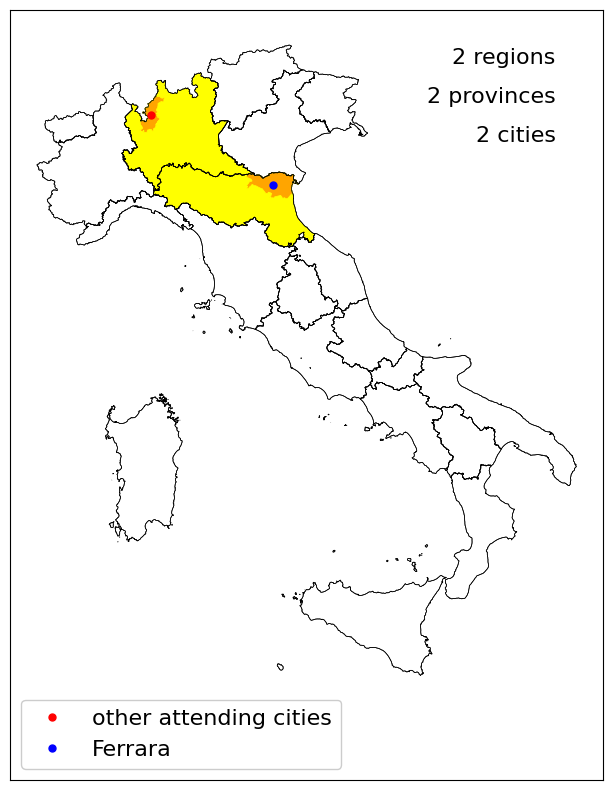

In [8]:
bPlotThis = True
if bPlotThis:

    # plot bkg map & highlight active regions/provinces
    ax = df_map_reg.boundary.plot(figsize=(8, 8), lw=0.5, color="k")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    dfBool = False
    for s in df_data.region.unique():
        dfBool = dfBool | (df_map_reg.NOME_REG == lsRegions[s])
    df_map_reg[dfBool].plot(ax = ax, lw=0.5, color="yellow") ;
    
    dfBool = False
    for s in df_data.province.unique():
        dfBool = dfBool | (df_map_prov.NOME_PRO == s.upper())
    df_map_prov[dfBool].boundary.plot(ax = ax, lw=0.5, color="yellow") ;
    df_map_prov[dfBool].plot(ax = ax, lw=0.5, color="orange") ;
    df_map_reg.boundary.plot(ax = ax, lw=0.5, color="k")

    # plot single institutions
    for i, s in enumerate(list(df_data.locationName.unique())):
        y = df_data[df_data.locationName==s].latitude[min(df_data[df_data.locationName==s].index)]
        x = df_data[df_data.locationName==s].longitude[min(df_data[df_data.locationName==s].index)]
        ax.plot(x, y, color="blue" if s=="Ferrara" else "red", marker="o", ms=5, lw=0, label="Ferrara" if s=="Ferrara" else "other attending cities" if i==0 else None)

    plt.legend(fontsize=fontsize, loc="lower left", framealpha=1)
    plt.text(0.92, 0.95,"%d regions" % len(df_data.region.unique()), fontsize=fontsize, horizontalalignment="right", verticalalignment="top", transform=ax.transAxes)
    plt.text(0.92, 0.90,"%d provinces" % len(df_data.province.unique()), fontsize=fontsize, horizontalalignment="right", verticalalignment="top", transform=ax.transAxes)
    plt.text(0.92, 0.85,"%d cities" % len(df_data.locationName.unique()), fontsize=fontsize, horizontalalignment="right", verticalalignment="top", transform=ax.transAxes)
    
    plt.tight_layout()
    
    if bSavePlots:
        plt.savefig("./out_final_plots/%s/cities.%s" % (yr, fmt))

C:\Users\succo\miniconda3\envs\envGeo\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
C:\Users\succo\miniconda3\envs\envGeo\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


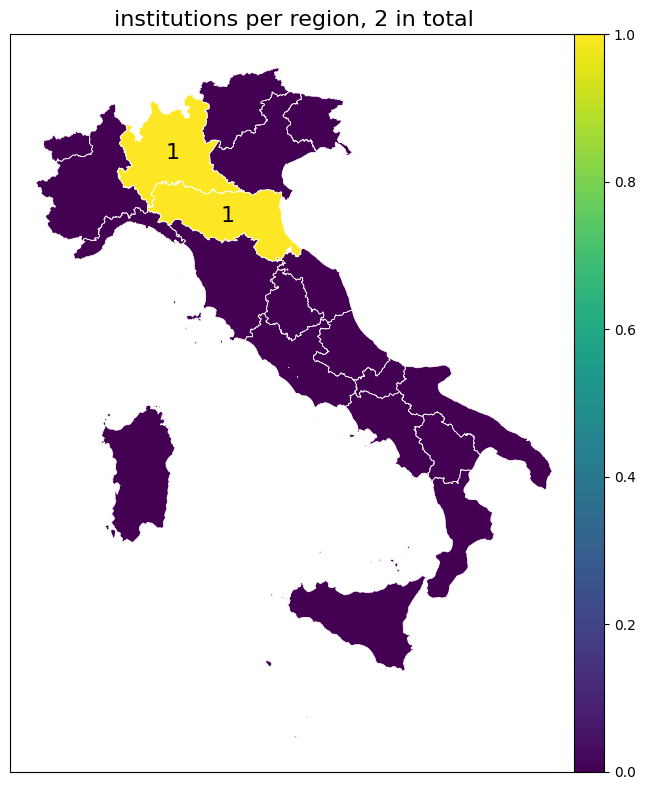

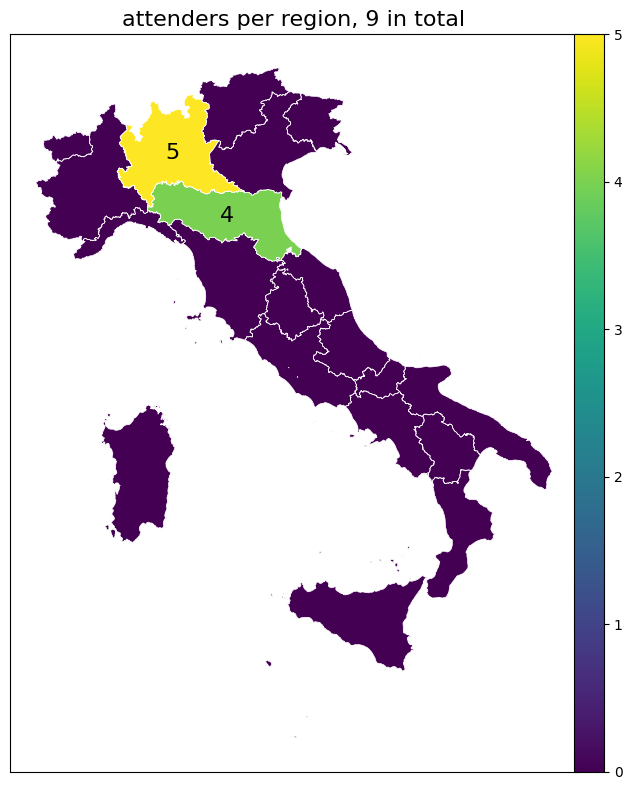

In [9]:
bPlotThis = True
if bPlotThis:
    
    # map w/ institutions per region
    # plot
    ax = df_map_reg.boundary.plot(lw=0.5, color="w", figsize=(8, 8))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad="-13%")
    df_map_reg.plot(ax=ax, column="nInstitutions", cax=cax, legend=True)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("institutions per region, %d in total" % sum(df_map_reg.nInstitutions), fontsize=fontsize)
    plt.tight_layout()
    
    # text boxes w/ numbers
    for i in df_map_reg.index:
        if df_map_reg.nInstitutions[i]>0:
            x, y = df_map_reg.geometry[i].centroid.x, df_map_reg.geometry[i].centroid.y
            color="black" if df_map_reg.nInstitutions[i]>0.5*max(df_map_reg.nInstitutions) else "0.7"
            ax.text(x, y, "%d" % df_map_reg.nInstitutions[i], fontsize=fontsize, color=color, horizontalalignment="center", verticalalignment="center")
            
    if bSavePlots:
        plt.savefig("./out_final_plots/%s/regions_nInstitutions.%s" % (yr, fmt))
    
    # map w/ students per region
    # plot
    ax = df_map_reg.boundary.plot(lw=0.5, color="w", figsize=(8, 8))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad="-13%")
    df_map_reg.plot(ax=ax, column="nAttenders", cax=cax, legend=True)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("attenders per region, %d in total" % sum(df_map_reg.nAttenders), fontsize=fontsize)
    plt.tight_layout()
    
    # text boxes w/ numbers
    for i in df_map_reg.index:
        if df_map_reg.nAttenders[i]>0:
            x, y = df_map_reg.geometry[i].centroid.x, df_map_reg.geometry[i].centroid.y
            color="black" if df_map_reg.nAttenders[i]>0.5*max(df_map_reg.nAttenders) else "0.7"
            ax.text(x, y, "%d" % df_map_reg.nAttenders[i], fontsize=fontsize, color=color, horizontalalignment="center", verticalalignment="center")
            
    if bSavePlots:
        plt.savefig("./out_final_plots/%s/regions_nAttenders.%s" % (yr, fmt))

### **institutions & students per province (for each region)**

C:\Users\succo\miniconda3\envs\envGeo\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
C:\Users\succo\miniconda3\envs\envGeo\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
C:\Users\succo\AppData\Local\Temp\ipykernel_10012\707419829.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\succo\miniconda3\envs\envGeo\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
C:\Users\succo\miniconda3\envs\e

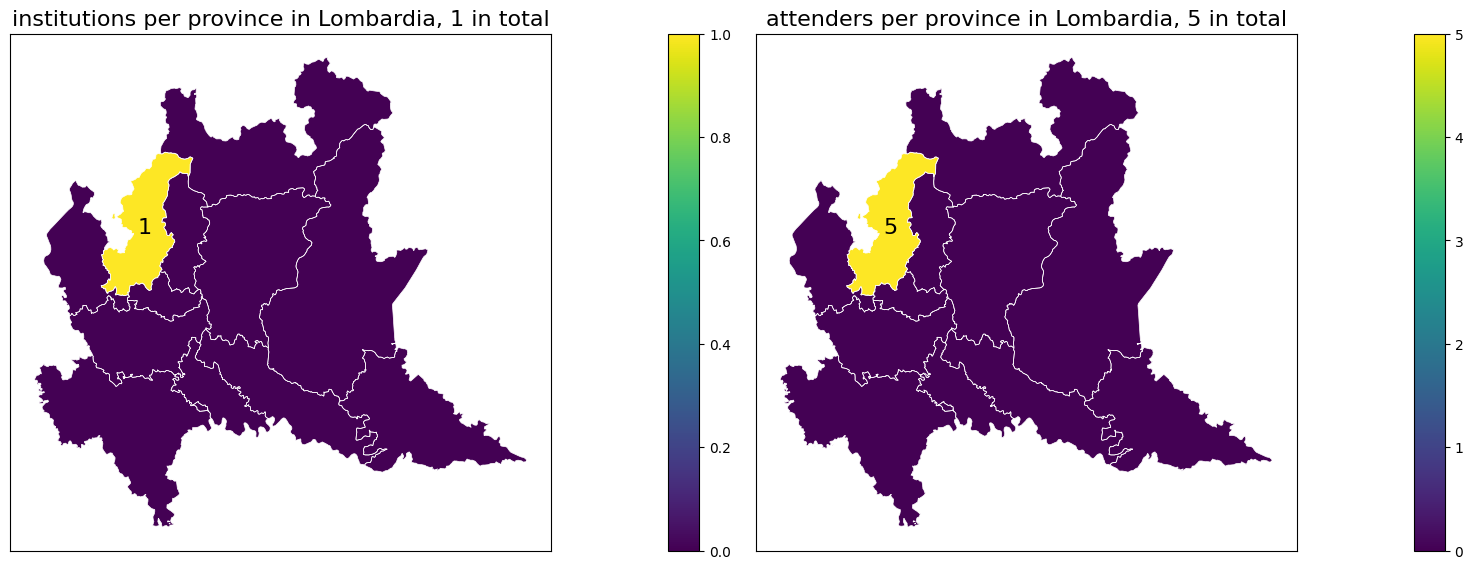

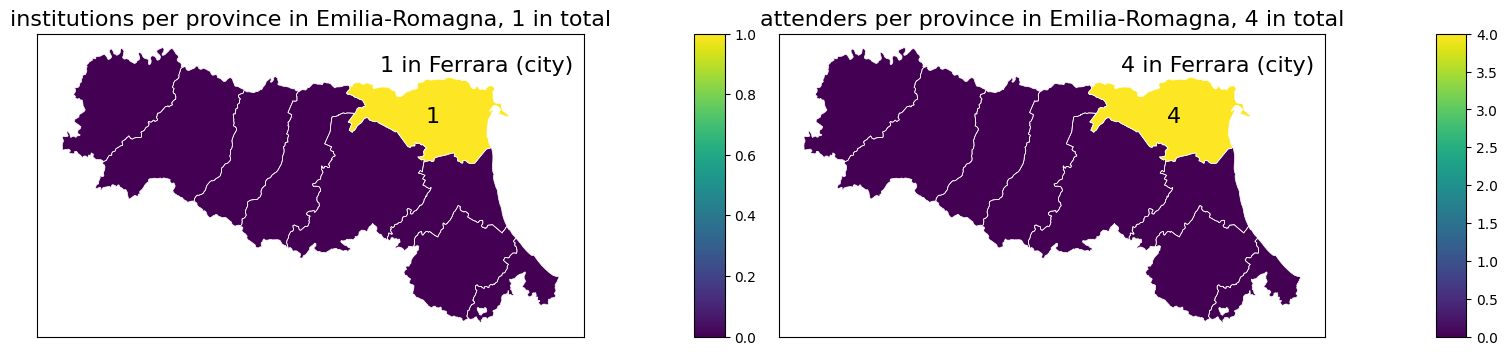

In [10]:
bPlotThis = True
if bPlotThis:
    
    for region in df_map_prov.NOME_REG.unique():
        dfTemp = df_map_prov[df_map_prov.NOME_REG == region]
        fig, ax = plt.subplots(ncols=2, figsize = (16, 8))
    
        # map w/ institutions per province
        # plot
        dfTemp.boundary.plot(ax = ax[0], lw=0.5, color="w")
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes("right", size="4%", pad="0.1%")
        dfTemp.plot(ax=ax[0], column="nInstitutions", cax=cax, legend=True)
        ax[0].get_xaxis().set_visible(False)
        ax[0].get_yaxis().set_visible(False)
        ax[0].set_title("institutions per province in %s, %d in total" % (lsRegionsSwapped[region], sum(dfTemp.nInstitutions)), fontsize=fontsize)
        plt.tight_layout()

        # text boxes w/ numbers
        for i in dfTemp.index:
            if dfTemp.nInstitutions[i]>0:
                x, y = dfTemp.geometry[i].centroid.x, dfTemp.geometry[i].centroid.y
                color="black" if dfTemp.nInstitutions[i]>0.5*max(dfTemp.nInstitutions) else "0.6"
                ax[0].text(x, y, "%d" % dfTemp.nInstitutions[i], fontsize=fontsize, color=color, horizontalalignment="center", verticalalignment="center")
                
        # comparison w/ Ferrara (city)
        if region=="EMILIA-ROMAGNA":
            plt.text(0.98, 0.93,"%d in Ferrara (city)" % len(df_data[df_data.locationName=="Ferrara"].institution_location.unique()), fontsize=fontsize, horizontalalignment="right", verticalalignment="top", transform=ax[0].transAxes)

        # map w/ students per province
        # plot
        dfTemp.boundary.plot(ax = ax[1], lw=0.5, color="w")
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="4%", pad="0.1%")
        dfTemp.plot(ax=ax[1], column="nAttenders", cax=cax, legend=True)
        ax[1].get_xaxis().set_visible(False)
        ax[1].get_yaxis().set_visible(False)
        ax[1].set_title("attenders per province in %s, %d in total" % (lsRegionsSwapped[region], sum(dfTemp.nAttenders)), fontsize=fontsize)
        plt.tight_layout()

        # text boxes w/ numbers
        for i in dfTemp.index:
            if dfTemp.nAttenders[i]>0:
                x, y = dfTemp.geometry[i].centroid.x, dfTemp.geometry[i].centroid.y
                color="black" if dfTemp.nAttenders[i]>0.5*max(dfTemp.nAttenders) else "0.6"
                ax[1].text(x, y, "%d" % dfTemp.nAttenders[i], fontsize=fontsize, color=color, horizontalalignment="center", verticalalignment="center")
                
        # comparison w/ Ferrara (city)
        if region=="EMILIA-ROMAGNA":
            plt.text(0.98, 0.93,"%d in Ferrara (city)" % len(df_data[df_data.locationName=="Ferrara"].fullName_institution_location.unique()), fontsize=fontsize, horizontalalignment="right", verticalalignment="top", transform=ax[1].transAxes)

        if bSavePlots:
            plt.savefig("./out_final_plots/%s/provinces_%s_nInstitutions_nAttenders.%s" % (yr, lsRegionsSwapped[region].replace(" ", "").replace("/", "").replace("'", ""), fmt))

### **miscellaneous**

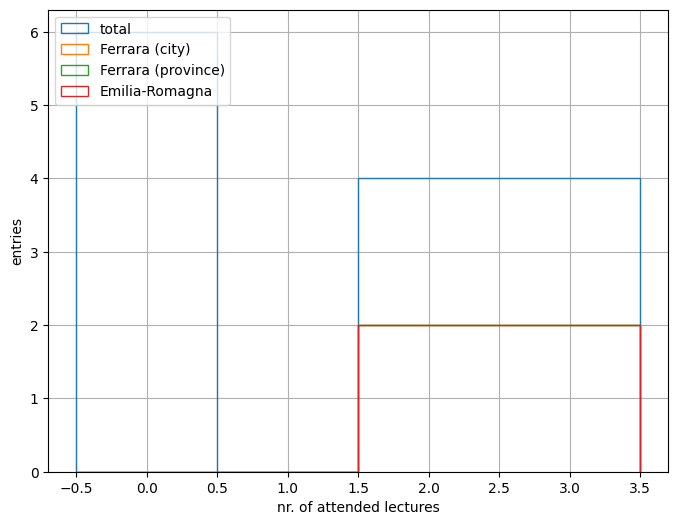

In [11]:
bPlotThis = True
if bPlotThis:
    
    # distribution of nr. of attended lectures
    # note: this assumes that there are attenders in Ferrara (city), in the province of Ferrara and in Emilia-Romagna
    plt.figure(figsize=(8, 6))
    
    plt.hist(df_data.nLectures, bins=nLectures+1, range=(-0.5, nLectures+0.5), histtype="step", label="total")
    plt.hist(df_data[df_data.locationName=="Ferrara"].nLectures, bins=nLectures+1, range=(-0.5, nLectures+0.5), histtype="step", label="Ferrara (city)")
    plt.hist(df_data[df_data.province=="Ferrara"].nLectures, bins=nLectures+1, range=(-0.5, nLectures+0.5), histtype="step", label="Ferrara (province)")
    plt.hist(df_data[df_data.region=="Emilia-Romagna"].nLectures, bins=nLectures+1, range=(-0.5, nLectures+0.5), histtype="step", label="Emilia-Romagna")
    
    plt.legend(loc="upper left")
    plt.xlabel("nr. of attended lectures")
    plt.ylabel("entries")
    plt.grid()
    
    if bSavePlots:
        plt.savefig("./out_final_plots/%s/histogram_attendedLectures.%s" % (yr, fmt))

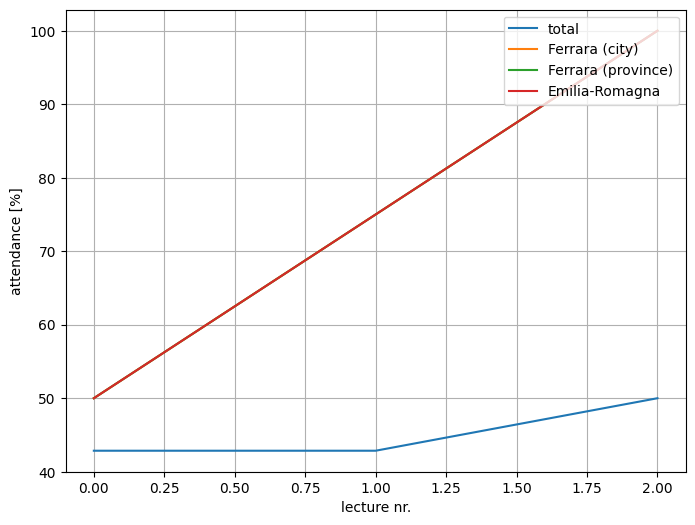

In [12]:
bPlotThis = True
if bPlotThis:
    
    # nr. of attenders per lecture
    # note: this assumes that there are attenders in Ferrara (city), in the province of Ferrara and in Emilia-Romagna
    plt.figure(figsize=(8, 6))
    
    x = range(nLectures)
    y_totalRegistered = [df_data.shape[0], df_data[df_data.locationName=="Ferrara"].shape[0], df_data[df_data.province=="Ferrara"].shape[0], df_data[df_data.region=="Emilia-Romagna"].shape[0]]
    y_national = []
    y_ferraraCity = []
    y_ferraraProv = []
    y_emiliaRomagna = []
    for i in x:
        y_national.append(df_data[df_data["presence%d" % i]].shape[0] / y_totalRegistered[0] * 100)
        y_ferraraCity.append(df_data[(df_data.locationName=="Ferrara") & (df_data["presence%d" % i])].shape[0] / y_totalRegistered[1] * 100)
        y_ferraraProv.append(df_data[(df_data.province=="Ferrara") & (df_data["presence%d" % i])].shape[0] / y_totalRegistered[2] * 100)
        y_emiliaRomagna.append(df_data[(df_data.region=="Emilia-Romagna") & (df_data["presence%d" % i])].shape[0] / y_totalRegistered[3] * 100)
        
    plt.plot(x, y_national, label="total")
    plt.plot(x, y_ferraraCity, label="Ferrara (city)")
    plt.plot(x, y_ferraraProv, label="Ferrara (province)")
    plt.plot(x, y_emiliaRomagna, label="Emilia-Romagna")
    
    plt.legend(loc="upper right")
    plt.xlabel("lecture nr.")
    plt.ylabel("attendance [%]")
    plt.grid()
    
    if bSavePlots:
        plt.savefig("./out_final_plots/%s/histogram_attendancePerLecture.%s" % (yr, fmt))